In [1]:
%load_ext autoreload
%autoreload 1
%aimport pycabnn 

/Users/shhong/Documents/Josefine/pycabnn/notebooks/pycabnn/connector.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycabnn as cbn

from scipy.spatial import KDTree
from scipy.spatial.distance import pdist
from scipy.optimize import curve_fit

import dask.dataframe as dd
from tqdm.dask import TqdmCallback
from dask.diagnostics import ProgressBar

from tqdm.autonotebook import tqdm, trange

In [3]:
from pycabnn.util import HocParameterParser

h = HocParameterParser()
config_hoc = str("../test_data/params/Parameters.hoc")
h.load_file(config_hoc)


In [4]:
mlipop = cbn.create_population("MLI", h)
mlipop.load_somata("../../big_test_data/MLIcoordinates.dat")
mlipop.add_dendrites()

Successfully read ../../big_test_data/MLIcoordinates.dat.


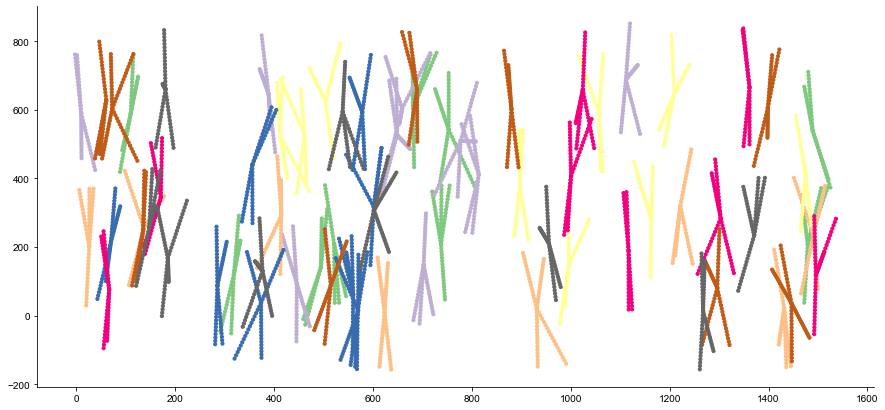

In [5]:
ncell = 70
nidx = ncell*90*4

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(
    mlipop.dends.coo[:nidx:5,0],
    mlipop.dends.coo[:nidx:5,1], 
    10, 
    mlipop.dends.idx[:nidx:5], 
    cmap='Accent'
)

In [6]:
dend_coo = np.reshape(mlipop.dends.coo, (-1, 4, 90, 3))
som = mlipop.som

In [105]:
def compute_soma_dist(som):
    temp1 = pdist(som[:,[1, 2]])
    temp2 = pdist(som[:, 0][:, np.newaxis])
    som_dist = pd.DataFrame(np.zeros((temp1.shape[0], 2), dtype=int), columns=['i', 'j'])
    ifirst = 0
    ilast = som.shape[0]-1
    for i in trange(som.shape[0]-1):
        som_dist.iloc[ifirst:ilast, 0] = i
        som_dist.iloc[ifirst:ilast, 1] = np.arange(i+1, som.shape[0], dtype=int)
        ifirst = ilast
        ilast = ifirst + som.shape[0]-(i+2)
        
    som_dist['dist_xy'] = temp1
    som_dist['dist_z'] = temp2
    return som_dist

som_dist = compute_soma_dist(mlipop.som)

som_dist = som_dist[som_dist['dist_xy'] < 180]
som_dist = som_dist[som_dist['dist_z'] < 50]

  0%|          | 0/19723 [00:00<?, ?it/s]

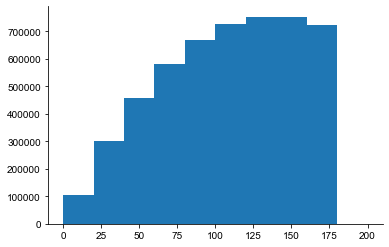

In [106]:
_ = plt.hist(som_dist['dist_xy'], bins=np.arange(0, 220, 20))

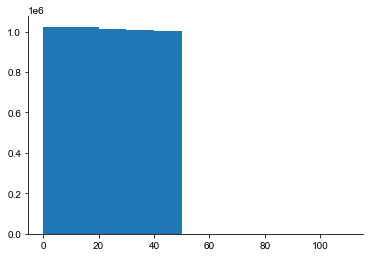

In [107]:
_ = plt.hist(som_dist['dist_z'], bins=np.arange(0, 120, 10))

In [108]:
Npair = som_dist.shape[0]

## Distance vs connectivity data

In [109]:
p_dist_xy = np.loadtxt('p_dist_xy.csv', delimiter=',')
p_dist_z = np.loadtxt('p_dist_z.csv', delimiter=',')

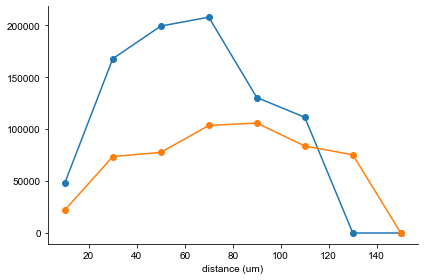

In [110]:
nxy, c = np.histogram(som_dist['dist_xy'], bins=np.arange(0, 180, 20))

def plot_dist(x, y, fname):
    plt.plot(x, y, '-o')
    plt.xlabel("distance (um)")
    plt.tight_layout()
    plt.savefig(fname)
    
plot_dist(p_dist_xy[:,0], nxy[:,np.newaxis]*p_dist_xy[:,1:], 'MLI_fit_conn_func/pdata_xy.png')

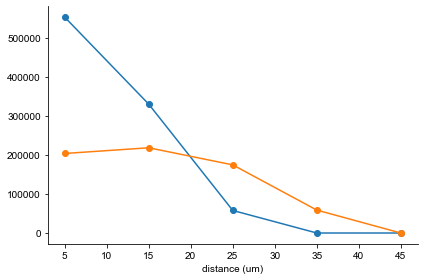

In [111]:
nz, c = np.histogram(som_dist['dist_z'], bins=np.arange(0, 60, 10))
plot_dist(p_dist_z[:,0], nz[:,np.newaxis]*p_dist_z[:,1:], 'MLI_fit_conn_func/pdata_z.png')

In [104]:
c, nz
sum(nxy), sum(nz)

(5070134, 5070134)

### Fit: XY

In [112]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))*x

p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,1], p0=[50, 0.001, 100000])
print(p_xy[0])

[2.08043970e+01 2.55078353e-04 5.31416508e+03]


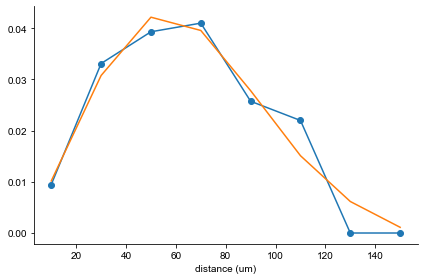

In [116]:
def plot_dist2(x, y, y2, fname=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(x, y, "o-", x, y2)
    ax.set_xlabel("distance (um)")
    if fname:
        plt.tight_layout()
        plt.savefig(fname)


plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 1] * nxy/Npair,
    f_fit(p_dist_xy[:, 0], *p_xy[0])/ (1 + np.exp((p_dist_xy[:, 0] - 150) / 7))/Npair,
    "MLI_fit_conn_func/pdist_gap_xy_fit.png",
)


In [114]:
Pcon = (f_fit(p_dist_xy[:, 0], *p_xy[0])/ (1 + np.exp((p_dist_xy[:, 0] - 150) / 7))).sum()/Npair
print(Pcon)

0.17286267144746512


In [101]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 1],
    f_fit(p_dist_xy[:, 0], *p_xy[0]) / nxy,
    "MLI_fit_conn_func/ppost_gap_xy_fit.png",
)

ValueError: operands could not be broadcast together with shapes (8,) (9,) 

In [97]:
p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,2], p0=[50, 0.001, 100000])

plot_dist2(
    p_dist_xy[:, 0],
    nxy * p_dist_xy[:, 2],
    f_fit(p_dist_xy[:, 0], *p_xy[0]),
    "MLI_fit_conn_func/pdata_syn_xy_fit.png",
)

ValueError: operands could not be broadcast together with shapes (9,) (8,) 

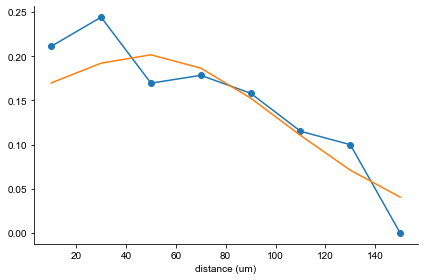

In [17]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 2],
    f_fit(p_dist_xy[:, 0], *p_xy[0]) / nxy,
    "MLI_fit_conn_func/ppost_syn_xy_fit.png"
)

### Fit XY with prior fit

In [54]:
xx = np.arange(10, 190, 20)
nxy, _ = np.histogram(som_dist['dist_xy'], bins=np.arange(0, 200, 20))

In [70]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))*x

p_pxy = curve_fit(f_fit, xx, nxy, p0=[50, 0.001, 100000])
p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy[:-1]*p_dist_xy[:,1], p0=[50, 0.001, 100000])
print(p_pxy[0])
print(p_xy[0])

[-8.93876558e+01  1.59471902e-05  1.24690154e+04]
[2.08043970e+01 2.55078353e-04 5.31416508e+03]


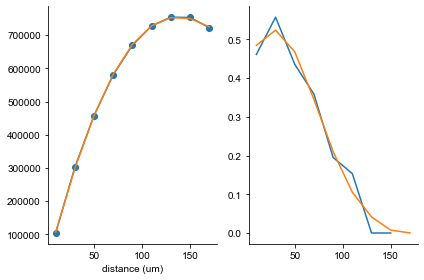

In [69]:
_, (ax1, ax2) = plt.subplots(ncols=2)

plot_dist2(xx, nxy, f_fit(xx, *p_pxy[0]), ax=ax1)
ax2.plot(p_dist_xy[:, 0], p_dist_xy[:, 1])
ax2.plot(
    xx, f_fit(xx, *p_xy[0]) / f_fit(xx, *p_pxy[0]) / (1 + np.exp((xx - 150) / 7)),
)
plt.tight_layout()
plt.savefig("MLI_fit_conn_func/ppost_gap_xy+prior_fit.png")


In [73]:
(f_fit(xx, 20.8, 2.55e-4, 5314) / (1 + np.exp((xx - 150) / 7))).sum()/Npair

0.17291144534287523

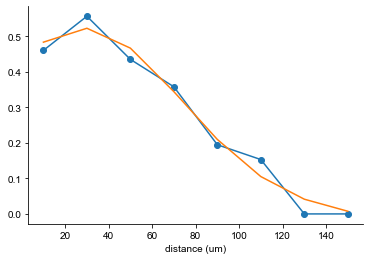

In [71]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 1],
    f_fit(p_dist_xy[:, 0], 20.8, 2.55e-4, 5314)
    / f_fit(p_dist_xy[:, 0], -89, 1.6e-5, 12469) / (1 + np.exp((p_dist_xy[:, 0] - 150) / 7)),
)
plt.savefig("MLI_fit_conn_func/ppost_gap_xy_final.png")

In [22]:
p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,2], p0=[50, 0.001, 100000])
print(p_xy[0])

[3.31682905e+01 1.64911617e-04 1.93526142e+03]


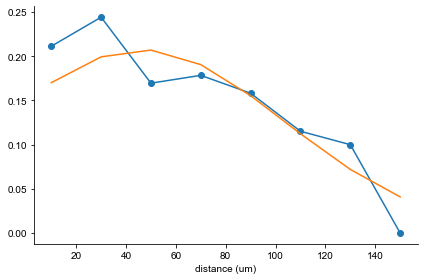

In [23]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 2],
    f_fit(p_dist_xy[:, 0], 33, 1.65e-4, 2000)
    / f_fit(p_dist_xy[:, 0], -110, 1.4e-5, 13177),
    "MLI_fit_conn_func/ppost_syn_xy_final.png",
)


### Fit: Z

In [82]:
def f_fit(x, mu, a, N):
    return N * np.exp(-a * (x - mu) * (x - mu))

p_pz = curve_fit(f_fit, p_dist_z[:, 0], nz, p0=[30, 0.001, 100000])
p_z = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,1], p0=[10, 0.001, 100000])
print(p_pz[0])
print(p_z[0])



[-2.83749333e+01  5.52355320e-06  1.03121203e+06]
[5.82232706e+00 6.17339375e-03 5.54723049e+05]


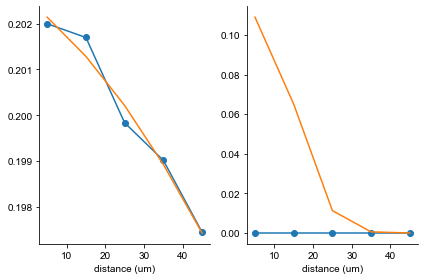

In [96]:
_, (ax1, ax2) = plt.subplots(ncols=2)

plot_dist2(p_dist_z[:, 0], nz/Npair, f_fit(p_dist_z[:, 0], *p_pz[0])/Npair, ax=ax1)
plot_dist2(
    p_dist_z[:, 0],
    p_dist_z[:, 1]*0,
    f_fit(p_dist_z[:, 0], *p_z[0])/Npair,
    ax=ax2,
)
plt.tight_layout()
plt.savefig("MLI_fit_conn_func/ppost_gap_z+prior_fit.png")

In [84]:
Pcon = (f_fit(p_dist_z[:, 0], *p_pz[0])).sum()/Npair
print(Pcon)

0.9999999970403046


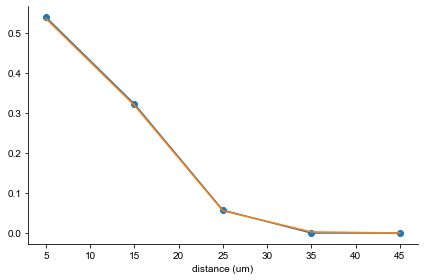

In [32]:
plot_dist2(
    p_dist_z[:, 0],
    p_dist_z[:, 1],
    f_fit(p_dist_z[:, 0], 5.8, 6.17e-3, 5.54e5) / f_fit(p_dist_z[:, 0], 0, 0, 1.03e6),
    "MLI_fit_conn_func/ppost_gap_z_final.png",
)


In [33]:
p_z = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,2], p0=[10, 0.001, 100000])
print(p_z[0])

[1.28960198e+01 2.64170525e-03 2.33702630e+05]


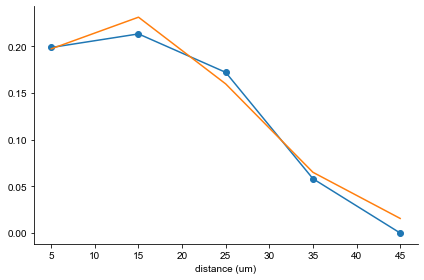

In [37]:
plot_dist2(
    p_dist_z[:, 0],
    p_dist_z[:, 2],
    f_fit(p_dist_z[:, 0], 13, 2.642e-3, 2.337e5) / f_fit(p_dist_z[:, 0], 0, 0, 1e6),
    "MLI_fit_conn_func/ppost_syn_z_final.png",
)